In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
%matplotlib inline

In [2]:
t_titre = 35
t_label = 25
fig_width= 15

In [3]:
observer = 'LB'
mode = 'enregistrement'
from aSPEM import Analysis
e = Analysis()#observer=observer, mode=mode)

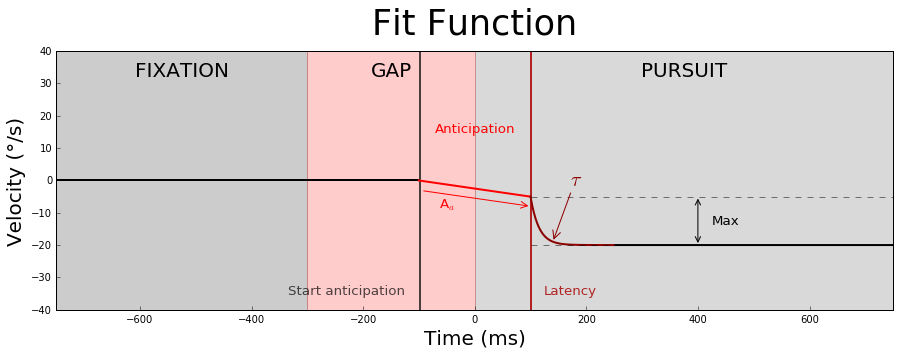

In [4]:
fig, axs= e.plot_fit_fonction()

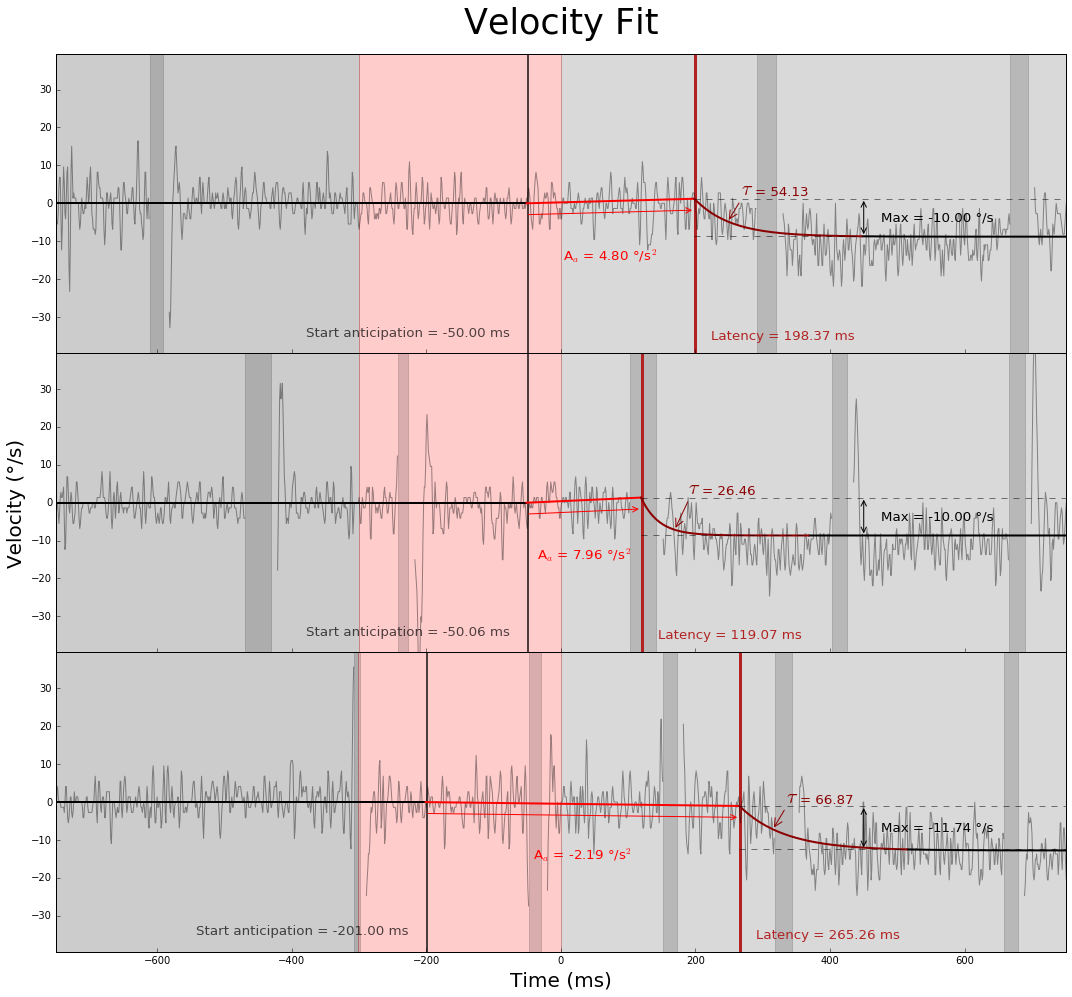

In [5]:
fig, axs= e.plot_velocity_fit()

### Fit

In [6]:
# pour générer les paramètre fit ainsi que les figures de tout les essais
#e.Fit()

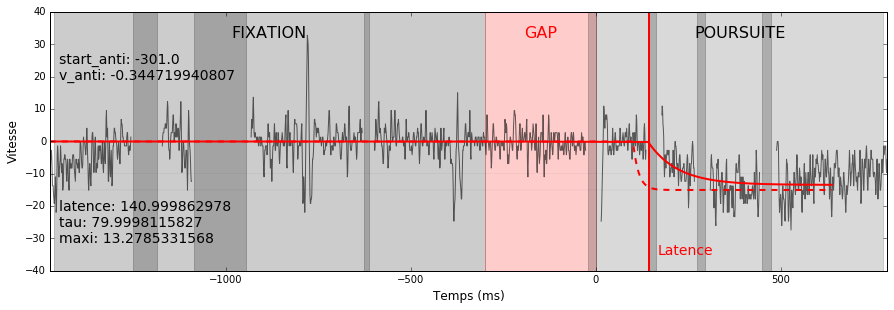

[[Model]]
    Model(exponentiel)
[[Fit Statistics]]
    # function evals   = 131
    # data points      = 1702
    # variables        = 5
    chi-square         = 97648.733
    reduced chi-square = 57.542
    Akaike info crit   = 6902.373
    Bayesian info crit = 6929.570
[[Variables]]
    tau:          79.9998115 +/- 54.78594 (68.48%) (init= 15)
    maxi:         13.2785331 +/- 1.281847 (9.65%) (init= 15)
    latence:      1649.99986 +/- 19.71955 (1.20%) (init= 1609)
    start_anti:   1208       +/- 2.78e+03 (229.89%) (init= 1409)
    v_anti:      -0.34471994 +/- 2.559741 (742.56%) (init=-0)
    bino:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(tau, latence)              =  0.895 
    C(maxi, v_anti)              =  0.856 
    C(start_anti, v_anti)        = -0.798 
    C(maxi, start_anti)          = -0.672 
    C(tau, maxi)                 = -0.239 
    C(maxi, latence)             = -0.236 
    C(tau, start_anti)           = -0.167 
    C(tau, v_an

/usr/local/lib/python3.5/dist-packages/lmfit/printfuncs.py:140: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({0:.2%})'.format(abs(par.stderr/par.value))


In [7]:
# pour voir un essai
fig, axs, report = e.Fit_essai()
print(report)